In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# compare with tesorflow
import tensorflow as tf
from tensorflow import keras

# Load the data
data = pd.read_table("./data/abalone.data", delimiter=",", header=None)

# Convert categorical data to numerical
data[0] = pd.factorize(data[0])[0]

# Split the data into features (X) and target (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]    

# Normalize the data
X = (X - X.mean()) / X.std()

# scale the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X)) 

# Scale the data the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200
X.iloc[:, 1] = X.iloc[:, 1] / 200

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
# Split the data into batches

In [267]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        # output_gradient is the derivative of the loss function with respect to the output of the layer
        pass


class Active(Layer):
    def __init__(self, active, active_derivative):
        self.active = active
        self.active_derivative = active_derivative

    def forward(self, input):
        # print("active input", input, input.shape)
        # print("active output", self.active(input), self.active(input).shape)
        self.input = input
        return self.active(self.input)

    def backward(self, output_gradient, learning_rate):
        input_grad = np.multiply(output_gradient, self.active_derivative(self.input))
        # print("active output_gradient", output_gradient, output_gradient.shape)
        # print("active input_grad", input_grad, input_grad.shape)
        return input_grad


class Sigmoid(Active):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_derivative(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_derivative)


class ReLU(Active):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_derivative(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_derivative)


class _Layer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        # print("Layer inputs", self.input, self.input.shape)
        # print("Layer weights", self.weights, self.weights.shape)
        # print("Layer bias", self.bias, self.bias.shape)
        # print("Layer output", (np.dot(self.weights, self.input)).reshape(-1,1) + self.bias)
        return (np.dot(self.weights, self.input)).reshape(-1,1) + self.bias

    def backward(self, output_gradient, learning_rate):
        # print("Layer input_gradient", output_gradient, output_gradient.shape)
        # print("Layer input", self.input, self.input.shape)
        if(len(self.input.shape) == 1):
            self.input = self.input.reshape(-1,1)
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        # print("Layer output_grad", input_gradient, input_gradient.shape)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [268]:
def mean_sq_err(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))


def mean_sq_err_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [269]:
class Neural_Network:

    def __init__(
        self, n_inputs_attr, n_hidden_layers, nodes_in_hidden_layers, n_outputs
    ):
        self.layers = []
        for i in range(n_hidden_layers):
            if i == 0:
                self.layers.append(_Layer(n_inputs_attr, nodes_in_hidden_layers[i]))
            else:
                self.layers.append(
                    _Layer(nodes_in_hidden_layers[i - 1], nodes_in_hidden_layers[i])
                )
            self.layers.append(Sigmoid())
        if n_hidden_layers > 0:
            self.layers.append(_Layer(nodes_in_hidden_layers[-1], n_outputs))
        else:
            self.layers.append(_Layer(n_inputs_attr, n_outputs))
        self.layers.append(ReLU())

    def predict(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def predict_test(self,X_test):
        y_pred = []
        for x in X_test:
            output = self.predict(x)
            y_pred.append(output)
        return np.array(y_pred).reshape(-1, 1)

    def train(
        self,
        loss,
        loss_derivative,
        x_train,
        y_train,
        epochs=10,
        learning_rate=0.01,
        verbose=True,
    ):
        batch_size = 32        
        X_train_batches = np.array_split(X_train, len(X_train)/batch_size)
        y_train_batches = np.array_split(y_train, len(y_train)/batch_size)
        for i in range(len(X_train_batches)):
            x_train = X_train_batches[i]
            y_train = y_train_batches[i]
            for e in range(epochs):
                error = 0
                for x, y in zip(x_train, y_train):
                    # print("Input", x)
                    # print("Target", y)
                    # forward
                    output = self.predict(x)
                    # print("Output", output)

                    # error
                    error += loss(y, output)

                    # backward
                    grad = loss_derivative(y, output)
                    for layer in reversed(self.layers):
                        grad = layer.backward(grad, learning_rate)

                error /= len(x_train)
                if verbose:
                    print(f"{e + 1}/{epochs}, error={error}")

    def calculate_mean_loss(self, X, y):
        loss = 0
        for x, y in zip(X, y):
            output = self.predict(x)
            loss += mean_sq_err(y, output)
        return loss/len(X)

Configuration:  Hidden Layers: 0 Nodes in Hidden Layer: None
Mean loss 5.377701489546604


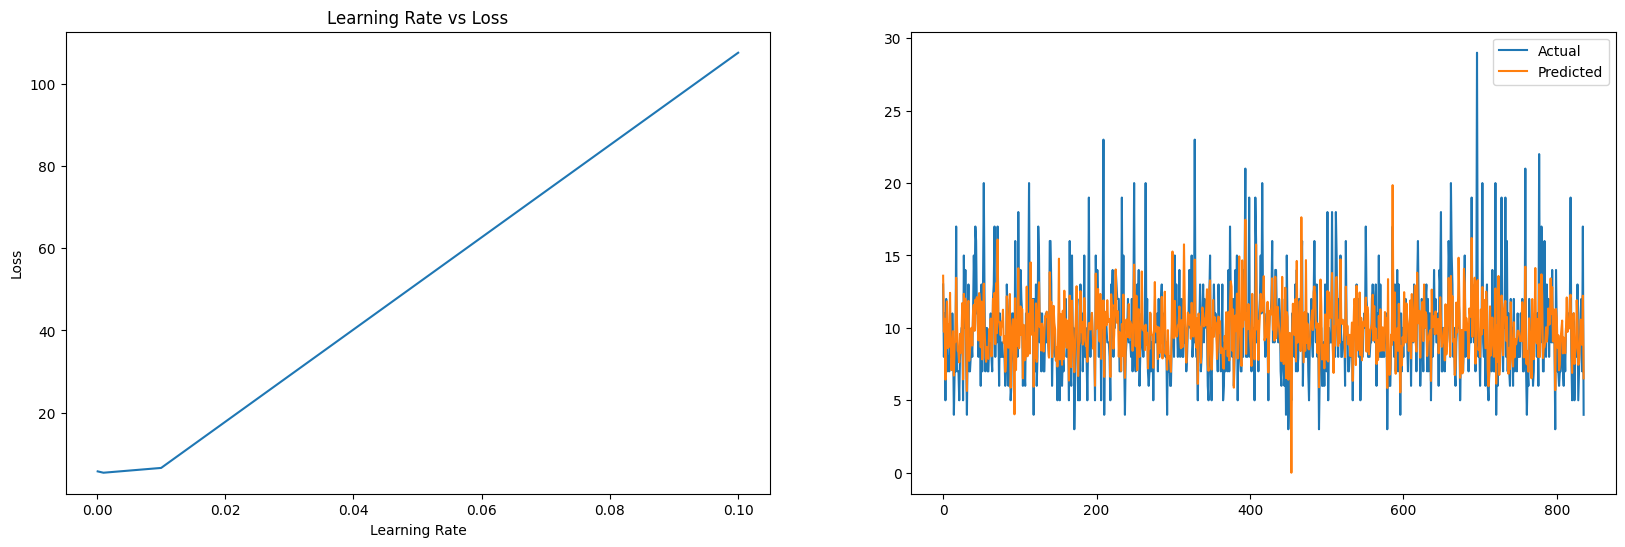

Configuration:  Hidden Layers: 1 Nodes in Hidden Layer: [32]
Mean loss 5.135149628793216


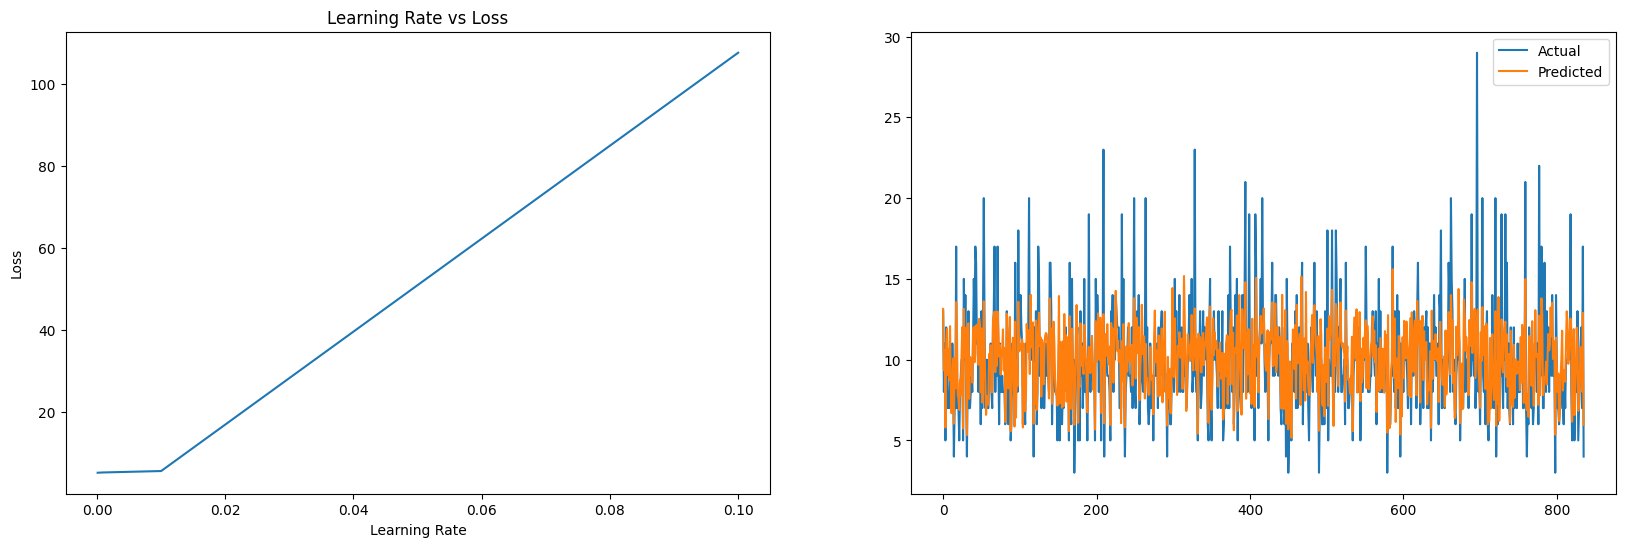

Configuration:  Hidden Layers: 1 Nodes in Hidden Layer: [64]
Mean loss 4.798303700612569


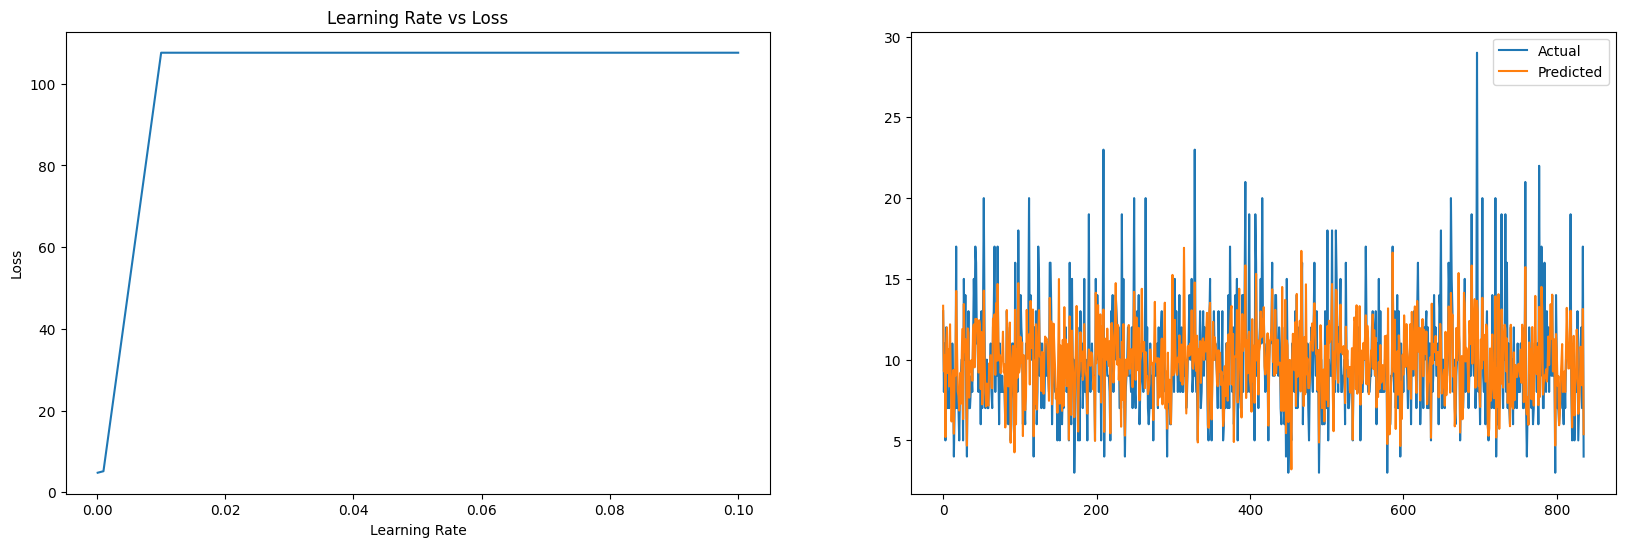

Configuration:  Hidden Layers: 2 Nodes in Hidden Layer: [32, 32]
Mean loss 4.798303700612569


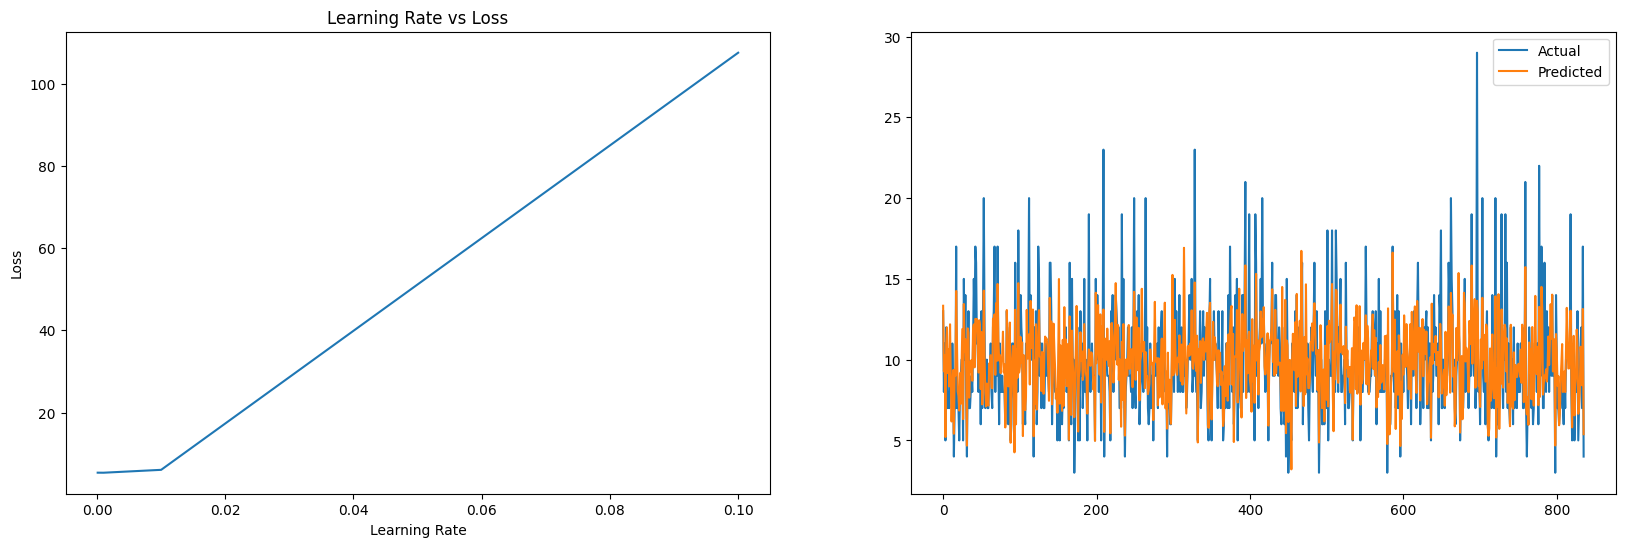

In [284]:
configurations = [[0, None], [1, [32]], [1, [64]], [2, [32, 32]]]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
best_neural_network = None
best_loss = None
best_y_pred = None
LOSSES = []
for config in configurations:
    loses = []
    n_hidden_layers = config[0]
    nodes_in_hidden_layers = config[1]

    for learning_rate in learning_rates:
        network = Neural_Network(
            X_train.shape[1], n_hidden_layers, nodes_in_hidden_layers, 1
        )
        network.train(
            mean_sq_err,
            mean_sq_err_derivative,
            X_train,
            y_train,
            10,
            learning_rate,
            False,
        )
        loss = network.calculate_mean_loss(X_test, y_test)
        loses.append(loss)
        if (
            best_neural_network == None
            or loss <= best_neural_network.calculate_mean_loss(X_test, y_test)
        ):
            best_neural_network = network
            best_loss = loss
            best_y_pred = network.predict_test(X_test)
    # print configuration
    print(
        "Configuration: ",
        "Hidden Layers:",
        n_hidden_layers,
        "Nodes in Hidden Layer:",
        nodes_in_hidden_layers,
    )
    y_pred = best_neural_network.predict_test(X_test)
    print("Mean loss", best_loss)

    LOSSES.append(loses)

    # plot the loses
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.plot(learning_rates, loses)
    ax1.set_title("Learning Rate vs Loss")
    ax1.set_xlabel("Learning Rate")
    ax1.set_ylabel("Loss")
    ax2.plot(y_test, label="Actual")
    ax2.plot(y_pred, label="Predicted")
    ax2.legend()
    plt.show()

Table Containing Configuration and Losses
Table Containing Configuration and Losses
Learning Rates		Config1		Config2		Config3		Config4
0.1000       		107.5861		107.5861		107.5861		107.5861		
0.0100       		6.5449 		5.5455 		107.5861		6.0453 		
0.0010       		5.3777 		5.2022 		5.1643 		5.3427 		
0.0001       		5.7048 		5.1351 		4.7983 		5.3541 		
Best Configuration
Hidden Layers: 1.0
Nodes in Hidden Layer: [64, 1]


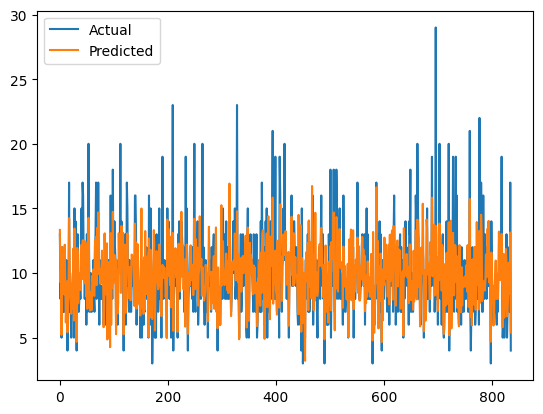

d:\COLLEGE RELATED\3RD YEAR\6TH SEMESTER\MACHINE LEARNING\ASSIGNMENT\.venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean loss 15.05573412607633


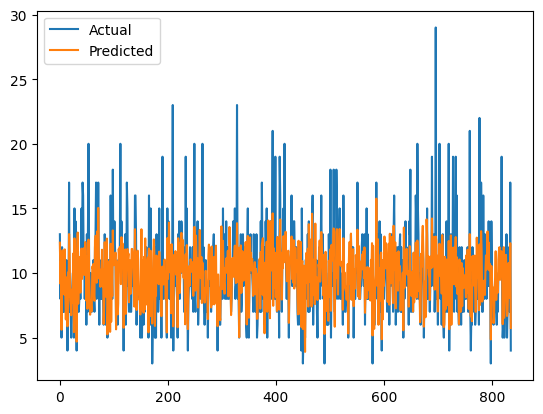

In [294]:
print("Table Containing Configuration and Losses")
print("Table Containing Configuration and Losses")
print("Learning Rates", "Config1", "Config2", "Config3", "Config4", sep="\t\t")
for i in range(len(learning_rates)):
    print(f"{learning_rates[i]:<13.4f}", end="\t\t")
    for j in range(len(LOSSES)):
        print(f"{LOSSES[j][i]:<7.4f}", end="\t\t")
    print()
print("Best Configuration")
print("Hidden Layers:", len(best_neural_network.layers) / 2 - 1)
print(
    "Nodes in Hidden Layer:",
    [
        layer.weights.shape[0]
        for layer in best_neural_network.layers
        if isinstance(layer, _Layer)
    ],
)
# print the target and predicted values
fig, ax = plt.subplots()
# plot the predicted and actual values for each test data
ax.figsize = (10, 6)
ax.plot(y_test, label="Actual")
ax.plot(best_y_pred, label="Predicted")
ax.legend()
plt.show()
# using best configuration with tensorflow
keras_layers = []
for layer in best_neural_network.layers:
    if isinstance(layer, _Layer):
        keras_layers.append(
            keras.layers.Dense(layer.weights.shape[0], input_shape=(X_train.shape[1],))
        )
    else:
        # if output layer the relu else sigmoid
        if len(keras_layers) == len(best_neural_network.layers) - 1:
            keras_layers.append(keras.layers.Activation("relu"))
        else:
            keras_layers.append(keras.layers.Activation("sigmoid"))

model = keras.Sequential(keras_layers)
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_tf = model.predict(X_test)
# print the losses
print("Mean loss", mean_sq_err(y_test, y_pred_tf))

fig, ax = plt.subplots()
# plot the predicted and actual values for each test data
ax.figsize = (10, 6)
ax.plot(y_test, label="Actual")
ax.plot(y_pred_tf, label="Predicted")
ax.legend()
plt.show()

In [295]:
# print the mean absolute error, mean squared error, and mean absolute percentage error
print("Tensorflow (Best Configuration)")
print("Mean Squared Error", mean_sq_err(y_test, y_pred_tf))
print("Mean Absolute Error", np.mean(np.abs(y_test - y_pred_tf)))
print(
    "Mean Absolute Percentage Error",
    np.mean(np.abs((y_test - y_pred_tf) / y_test)) * 100,
)
print()
# print the mean absolute error, mean squared error, and mean absolute percentage error
print("My Neural Network (Best Configuration)")
print("Mean Squared Error", mean_sq_err(y_test, best_y_pred))
print("Mean Absolute Error", np.mean(np.abs(y_test - best_y_pred)))
print(
    "Mean Absolute Percentage Error",
    np.mean(np.abs((y_test - best_y_pred) / y_test)) * 100,
)


Tensorflow (Best Configuration)
Mean Squared Error 15.05573412607633
Mean Absolute Error 3.000680552527695
Mean Absolute Percentage Error 34.15844396464329

My Neural Network (Best Configuration)
Mean Squared Error 15.888363722019452
Mean Absolute Error 3.081744175821368
Mean Absolute Percentage Error 35.10172357999981
